In [89]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch
# from utilsHannes import mean_pointwise_l2_distance

def mean_pointwise_l2_distance(lattice: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
    """
    Computes the index of the closest trajectory in the lattice as measured by l1 distance.
    :param lattice: Lattice of pre-generated trajectories. Shape [num_modes, n_timesteps, state_dim]
    :param ground_truth: Ground truth trajectory of agent. Shape [1, n_timesteps, state_dim].
    :return: Index of closest mode in the lattice.
    """
    stacked_ground_truth = ground_truth.repeat(lattice.shape[0], 1, 1)
    return torch.pow(lattice - stacked_ground_truth, 2).sum(dim=2).sqrt().mean(dim=1).argmin()


In [90]:
## Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories8 = pickle.load(f)
lattice8 = np.array(trajectories8)
              
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
    trajectories4 = pickle.load(f)
lattice4 = np.array(trajectories4)
    
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
    trajectories2 = pickle.load(f)
lattice2 = np.array(trajectories2)

In [91]:
############################# Modified logits CL ######################################

# # Save top15 run on server 9
# epochs = [298]
# legend_list = ['10*10 (298e) eps=4 top15']
# dataset_factor_list = [1]
# lattice_list = [lattice4]
# modes_list = [415]
# num_epochs = 298
# file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]

dataset_factor_list = [1,1,1,1,1,1,1,1,1,1]
lattice_list = [lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4]
modes_list = [415,415,415,415,415,415,415,415,415,415]

# Files

### IID - Balanced
folder_path = "saveResults/from_other_servers/FedOptimizer_8clients_IID_800Rounds"
fed_optimizer_list = ["FedAvg","FedAvgM","FedProx"]
file_suffix_list = [f"iid_balanced_C=8_Cf=1.0_Ef=1.0_B=8_E=1_R=800_Opt={fed_optimizer}_Lr=0.0001" for fed_optimizer in fed_optimizer_list]
legend_list = [f'{fed_optimizer}' for fed_optimizer in fed_optimizer_list]
num_epochs = 800

### Non-IID - Balanced
folder_path = "saveResults/from_other_servers/ClientNumber_non-IID"
num_clients_list = ['1','2','4','8']
file_suffix_list = [f"balanced_C={num_clients}_Cf=1.0_Ef=1.0_B=8_E=1_R=500_Opt=saveFedAvg_Lr=0.0001" for num_clients in num_clients_list]
legend_list = [f'{num_clients}' for num_clients in num_clients_list]
num_epochs = 500

# folder_path = "saveResults/from_other_servers/ClientFraction_non-IID"
# client_fraction_list = ['0.25','0.5','0.75','1.0']
# file_suffix_list = [f"balanced_C=8_Cf={client_fraction}_Ef=1.0_B=8_E=1_R=1000_Opt=FedAvg_Lr=0.0001" for client_fraction in client_fraction_list]
# legend_list = [f'{client_fraction}' for client_fraction in client_fraction_list]
# num_epochs = 1000

### IID - Non-Balanced
### Non-IID - Non-Balanced


# Settings
file_number = 0
train_boolean = 'no' # yes
num_files = len(file_suffix_list)

indices_loaded_list = [(np.load(f'{folder_path}/val_indices_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]
probabilities_list = [(np.load(f'{folder_path}/val_probabilities_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]
ground_truth_loaded_list = [(np.load(f'{folder_path}/val_ground_truth_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]

#################################################################################################################################


# Print the data
print(f"len(indices_loaded_list) = {len(indices_loaded_list)}")
print(f"len(probabilities_list) = {len(probabilities_list)}")
print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
print(f"indices_loaded_list[{file_number}].shape = {indices_loaded_list[file_number].shape}")
print(f"probabilities_list[{file_number}].shape = {probabilities_list[file_number].shape}")
print(f"ground_truth_loaded_list[{file_number}].shape = {ground_truth_loaded_list[file_number].shape}")


len(indices_loaded_list) = 4
len(probabilities_list) = 4
len(ground_truth_loaded_list) = 4
indices_loaded_list[0].shape = (256000, 15)
probabilities_list[0].shape = (256000, 15)
ground_truth_loaded_list[0].shape = (256000, 12, 2)


In [92]:
## Functions new

def get_sorted_most_likely_trajectories(sortedProbabilitiesIndices: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
    return sortedTrajectories


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories, train_boolean, dataset_factor): # -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = num_epochs # TODO, automate
    if train_boolean == 'yes':
        n_datapoints_per_epoch = 2048*dataset_factor # TODO, automate
    else:
        n_datapoints_per_epoch = 512*dataset_factor # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            min_ADE[d,e] = tmp_ADE
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)



In [93]:
############### Calculate and plot many files

k_nr_of_trajectories_many_files = 5

# New
sorted_predicted_trajectories_list = [get_sorted_most_likely_trajectories(indices_loaded, lattice) for indices_loaded, lattice in zip(indices_loaded_list, lattice_list)]
sorted_predicted_probabilities_list = probabilities_list.copy()

results2 = [get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories_many_files, train_boolean, dataset_factor) for sorted_predicted_trajectories, ground_truth_loaded, dataset_factor in zip(sorted_predicted_trajectories_list, ground_truth_loaded_list, dataset_factor_list)]
min_ADE_list, ave_ADE_list = zip(*results2)

print(f"len(sorted_predicted_probabilities_list) = {len(sorted_predicted_probabilities_list)}")
print(f"len(sorted_predicted_trajectories_list) = {len(sorted_predicted_trajectories_list)}")
print(f"sorted_predicted_probabilities_list[{file_number}].shape = {sorted_predicted_probabilities_list[file_number].shape}")
print(f"sorted_predicted_trajectories_list[{file_number}].shape = {sorted_predicted_trajectories_list[file_number].shape}")
# print(f"sortedTrajectories = {sorted_predicted_trajectories_list[0][2]}") # [0][0/1] and [0][2/3] the same

print(f"\nmin_ADE_list[{file_number}].shape = {min_ADE_list[file_number].shape}")
print(f"\nave_ADE_list[{file_number}].shape = {ave_ADE_list[file_number].shape}")
print(f"\nmin_ADE_list[{file_number}][-1] = {min_ADE_list[file_number][-1]}")
print(f"\nave_ADE_list[{file_number}][-1] = {ave_ADE_list[file_number][-1]}")



len(sorted_predicted_probabilities_list) = 4
len(sorted_predicted_trajectories_list) = 4
sorted_predicted_probabilities_list[0].shape = (256000, 15)
sorted_predicted_trajectories_list[0].shape = (256000, 15, 12, 2)

min_ADE_list[0].shape = (500,)

ave_ADE_list[0].shape = (500,)

min_ADE_list[0][-1] = 3.4986979458729373

ave_ADE_list[0][-1] = 8.510892961487558


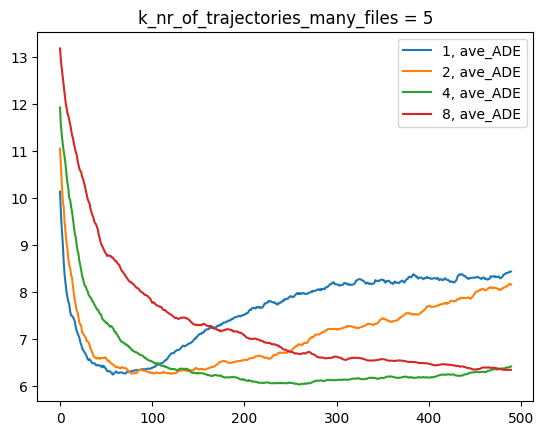

In [94]:
## Plot ADE
start_number = 1
window_size = 10
# [plt.plot(np.convolve(min_ADE[start_number:], np.ones(window_size)/window_size, mode='valid'), label=legend+', min_ADE') for min_ADE, legend in zip(min_ADE_list, legend_list)]
[plt.plot(np.convolve(ave_ADE[start_number:], np.ones(window_size)/window_size, mode='valid'), label=legend+', ave_ADE') for ave_ADE, legend in zip(ave_ADE_list, legend_list)]
plt.legend();
plt.title(f"k_nr_of_trajectories_many_files = {k_nr_of_trajectories_many_files}");

sorted_predicted_probabilities.shape = (256000, 15)
sorted_predicted_trajectories.shape = (256000, 15, 12, 2)

min_ADE.shape = (500,)

ave_ADE.shape = (500,)

min_ADE[-1] = 7.037248149180523

ave_ADE[-1] = 7.037248149180523


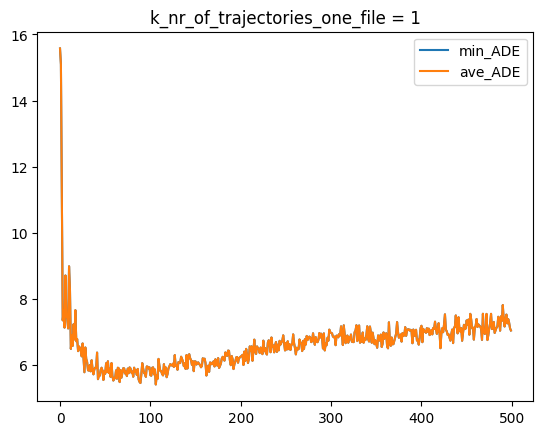

In [95]:
############## Calculate and plot one files
k_nr_of_trajectories_one_file = 1

# New
sorted_predicted_trajectories = get_sorted_most_likely_trajectories(indices_loaded_list[file_number], lattice_list[file_number])
sorted_predicted_probabilities = probabilities_list[file_number].copy()

min_ADE, ave_ADE = get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded_list[file_number], k_nr_of_trajectories_one_file, train_boolean, dataset_factor_list[file_number])

print(f"sorted_predicted_probabilities.shape = {sorted_predicted_probabilities.shape}")
print(f"sorted_predicted_trajectories.shape = {sorted_predicted_trajectories.shape}")
print(f"\nmin_ADE.shape = {min_ADE.shape}")
print(f"\nave_ADE.shape = {ave_ADE.shape}")
print(f"\nmin_ADE[-1] = {min_ADE[-1]}")
print(f"\nave_ADE[-1] = {ave_ADE[-1]}")

### One file ###
plt.plot(min_ADE, label="min_ADE")
plt.plot(ave_ADE, label="ave_ADE")
plt.legend();
plt.title(f"k_nr_of_trajectories_one_file = {k_nr_of_trajectories_one_file}");


predicted = 0
closest_lattice_index = 298
correct = False


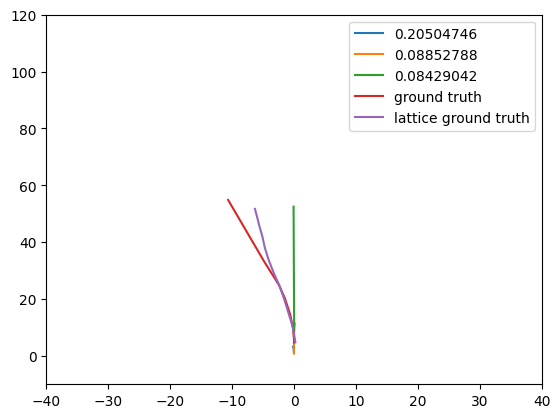

In [96]:
## Plot prediction vs ground truth
epoch = 200
index = 22
if train_boolean == 'yes':
    test_index = epoch*2048*dataset_factor_list[file_number] + index
else: 
    test_index = epoch*512*dataset_factor_list[file_number] + index
    
nrOfTopTrajectories = 3
ground_truth_trajectory = ground_truth_loaded_list[file_number][test_index]
probabilities = probabilities_list[file_number][test_index]
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory))
topProbabilitiesIndices = np.argsort(probabilities)[::-1][0:nrOfTopTrajectories]
topProbabilities = [probabilities[index] for index in topProbabilitiesIndices]

# Lattice ground truth
predicted = topProbabilitiesIndices[0]
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

# Plot predictions
[plt.plot(lattice_list[file_number][mode,:,0],lattice_list[file_number][mode,:,1], label=topProbabilities[i]) for i, mode in enumerate(topProbabilitiesIndices)]
# Plot ground truth
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="ground truth")
# Plot lattice ground truth
plt.plot(lattice_list[file_number][closest_lattice_index,:,0],lattice_list[file_number][closest_lattice_index,:,1], label="lattice ground truth")
plt.ylim([-10,120]); plt.xlim([-40,40]); plt.legend(); plt.show()

In [97]:
# ## Plot loss and accuracy

# # File names
# loss_acc_file_names = [f"{file_path}_loss_and_acc.txt" for file_path in file_path_list]

# # Create empty arrays to store the data from text files
# epochs = np.zeros((num_files, num_epochs))
# train_loss = np.zeros((num_files, num_epochs))
# val_loss = np.zeros((num_files, num_epochs))
# train_acc = np.zeros((num_files, num_epochs))
# val_acc = np.zeros((num_files, num_epochs))

# # Loop over the text files
# for i, filename in enumerate(loss_acc_file_names):
#     with open(filename, 'r') as f:
#         for j, line in enumerate(f):
#             if j == num_epochs:
#                 break
#             if line.startswith('Epoch'):
#                 parts = line.split(': ')
#                 epoch = int(parts[0].split('[')[1].split('/')[0])
#                 epochs[i][j] = epoch
#                 train_loss[i][j] = float(parts[2].split(' |')[0])
#                 val_loss[i][j] = float(parts[3].split(' |')[0])
#                 train_acc[i][j] = float(parts[4].split(' %')[0])
#                 val_acc[i][j] = float(parts[5].split(' %')[0])
# if num_files > 4:
#     val_loss[4,0] = val_loss[4,1]



# # Training loss
# plt.figure()
# for i in range(num_files):
#     plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(legend_list)
# plt.show()

# # Validation loss
# plt.figure()
# for i in range(num_files):
#     plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
# plt.title('Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(legend_list)
# plt.show()

# # Training accuracy
# plt.figure()
# for i in range(num_files):
#     plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
# plt.title('Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(legend_list)
# plt.show()

# # Validation accuracy
# plt.figure()
# for i in range(num_files):
#     # Convert the list to a pandas DataFrame
#     df = pd.DataFrame(val_acc[i])
#     # Apply a rolling window of size x and take the mean of each window
#     smoothed = df.rolling(5).mean()
#     # Convert the smoothed DataFrame back to a list
#     smoothed_list = smoothed.values.tolist()
#     numpy_smoothed_list = np.array(smoothed_list)
#     squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)
#     plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
# plt.title('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(legend_list)
# plt.show()


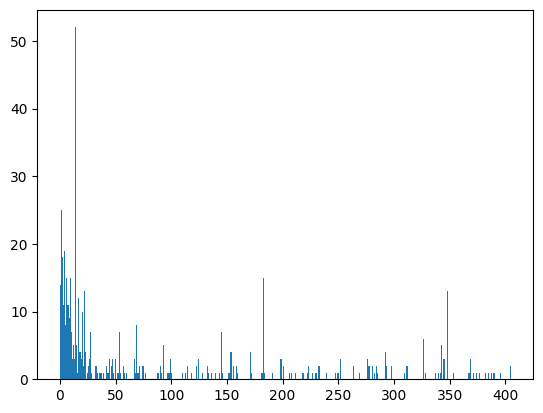

In [98]:
# Histogram of grount truth trajectories

if train_boolean == 'yes':
    nr_datapoints = 2048*dataset_factor_list[file_number]
else: 
    nr_datapoints = 512*dataset_factor_list[file_number]
    
closest_lattice_index = [mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory)) for ground_truth_trajectory in ground_truth_loaded_list[file_number][:nr_datapoints]]

plt.hist(closest_lattice_index, bins = modes_list[file_number]);
